# Full conformal prediction

In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import portion as P
from time import time
from tqdm import tqdm

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(4)

Data generating (see Zaffran's course on conformal prediction)

$$
X\sim Beta(6,3), \quad Y|X \sim \cos(X) + (1 - \cos(X))\mathcal{N}(0, 0.5)
$$

In [3]:
def sample_data(n):
    "Sample n data points from the given distribution"

    X = sp.stats.beta.rvs(a=6,b=3,loc=0,scale=6,size=n)

    ## Heteroscedastic model
    sigma = 0.5
    y = np.cos(X) + (1-np.cos(X))*sigma*np.random.normal(size=n)
    return X, y

In [4]:
def set_style():
    plt.rcParams["text.usetex"] = True
    font = {"family": "normal", "weight": "bold", "size": 22}
    plt.rc("font", **font)
    
set_style()

## Sample data

In [5]:
def sample_data_for_me(sample_size):
    # input_points, output_points = make_regression(sample_size + 1)
    input_points, output_points = sample_data(sample_size + 1)
    input_points = input_points.reshape(-1, 1)
    output_points = output_points.reshape(-1, 1)


    train_input_points = input_points[:-1, :]
    test_input_point = input_points[-1, :].reshape(1, -1)
    train_output_points = output_points[:-1, :]
    test_output_point = output_points[-1, :].reshape(1, -1)
    return train_input_points, train_output_points, test_input_point, test_output_point

In [6]:
sample_size = 200
train_input_points, train_output_points, test_input_point, test_output_point = (
    sample_data_for_me(sample_size)
)

## Non-conformity scores

### Utils

In [7]:
def compute_score_params(
    train_input_points, train_output_points, test_input_point, lam
):
    augmented_input_points = np.concatenate(
        (train_input_points, test_input_point.reshape(1, -1))
    )
    augmented_output_points = np.concatenate(
        (train_output_points, np.zeros((1, train_output_points.shape[1])))
    )

    # For polynomial regression
    augmented_input_points = poly.fit_transform(augmented_input_points)


    sample_size_p1 = augmented_input_points.shape[0]
    feature_number = augmented_input_points.shape[1]

    enp1 = np.zeros((sample_size_p1, 1))
    enp1[-1, :] = 1

    pre_intercept, _, _, _ = np.linalg.lstsq(
        (augmented_input_points.T @ augmented_input_points) / sample_size_p1
        + 2 * lam * np.eye(feature_number),
        augmented_input_points.T @ augmented_output_points,
    )
    intercept = (
        augmented_output_points
        - (augmented_input_points @ pre_intercept) / sample_size_p1
    )

    pre_weight, _, _, _ = np.linalg.lstsq(
        (augmented_input_points.T @ augmented_input_points) / sample_size_p1
        + 2 * lam * np.eye(feature_number),
        augmented_input_points.T @ enp1,
    )

    weight = enp1 - ((1 / sample_size_p1) * augmented_input_points @ pre_weight)

    return intercept.flatten(), weight.flatten()

In [8]:
def make_non_conformity_scores(intercept, weight):
    def non_conformity_scores(output_value):
        return np.abs(intercept + output_value * weight)

    return non_conformity_scores

### Run

In [9]:
lam = 0.5
intercept, weight = compute_score_params(
    train_input_points, train_output_points, test_input_point, lam
)
non_conformity_scores_ = make_non_conformity_scores(intercept, weight)

### Display

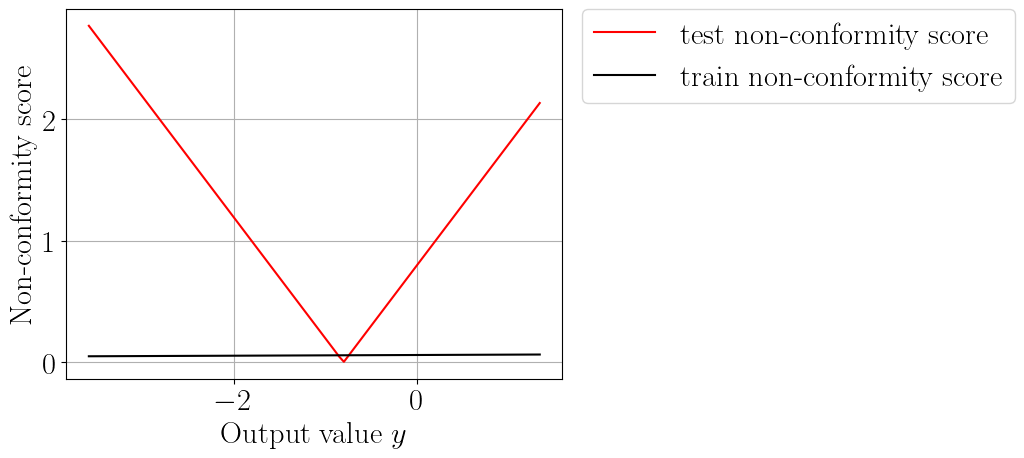

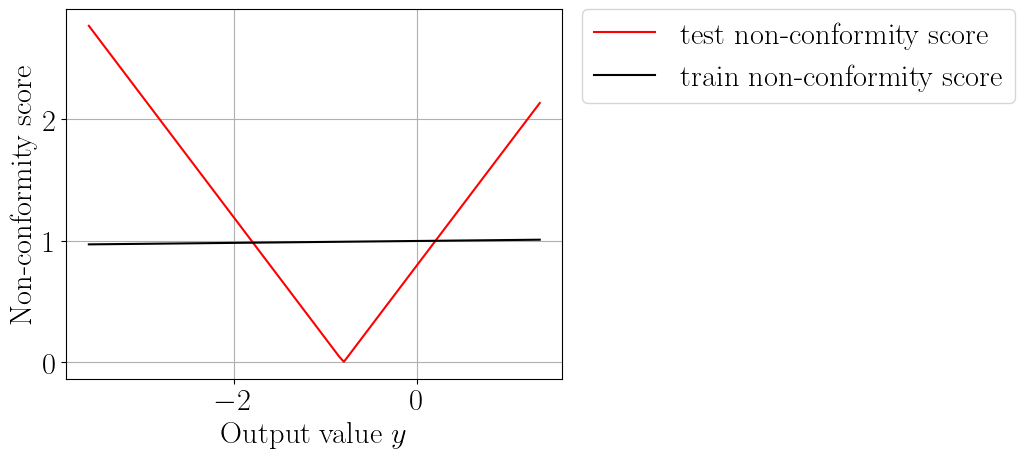

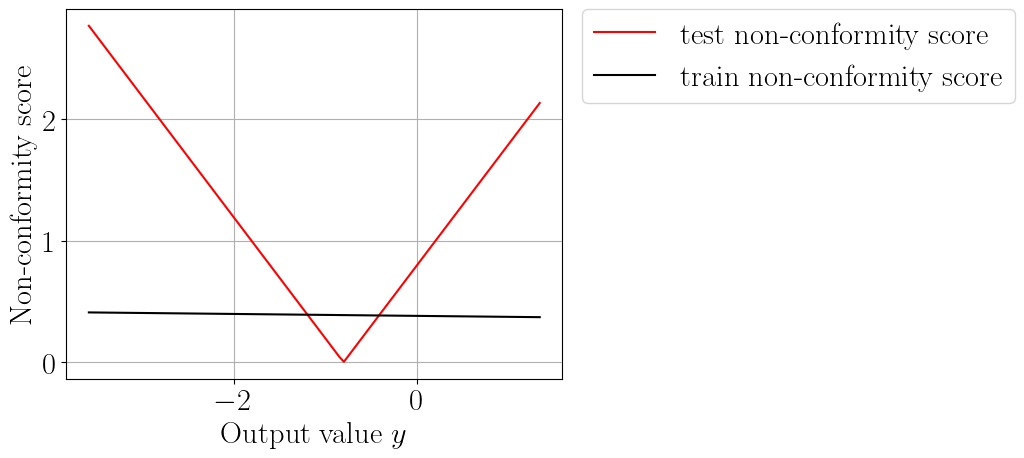

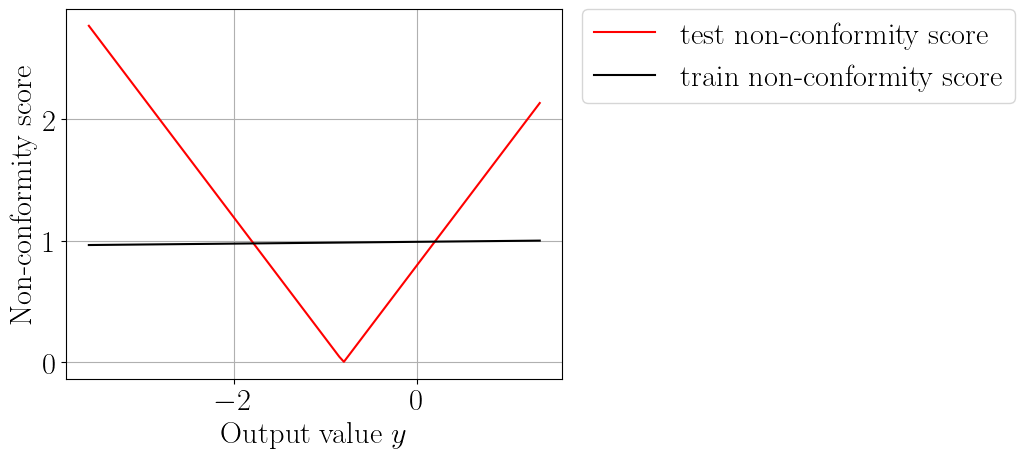

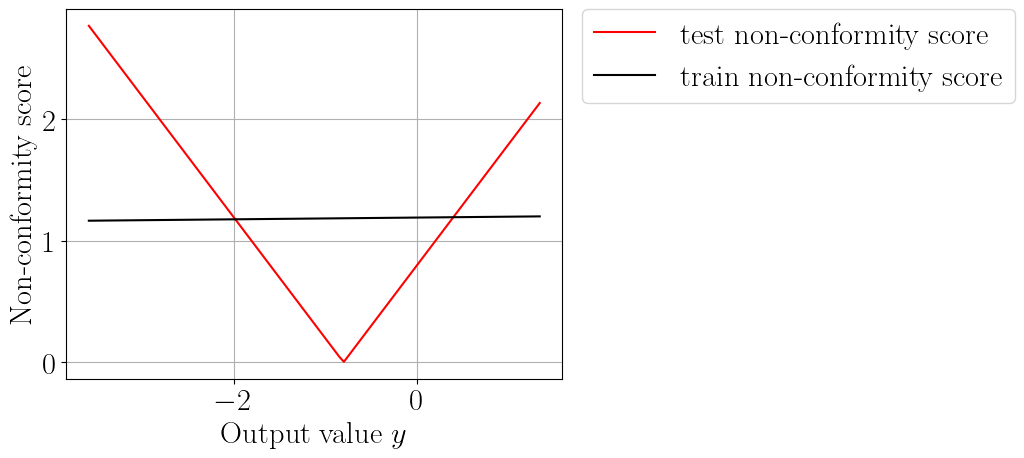

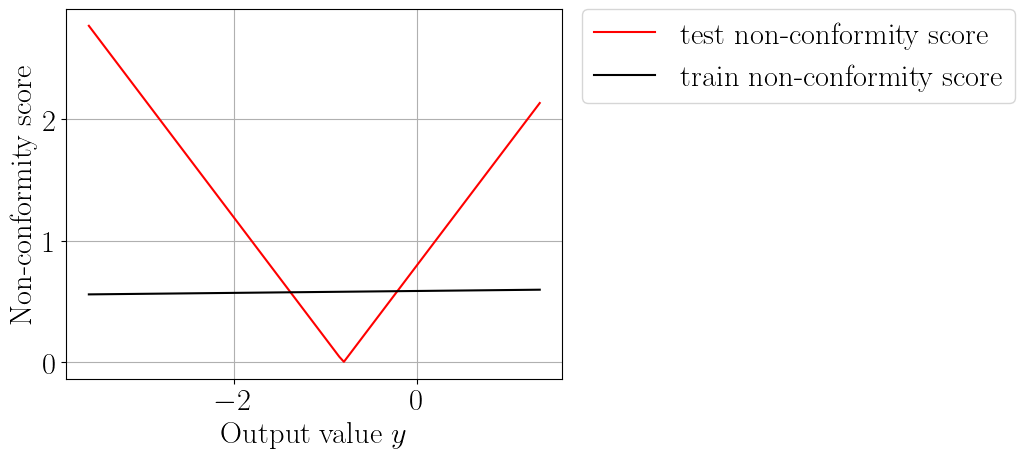

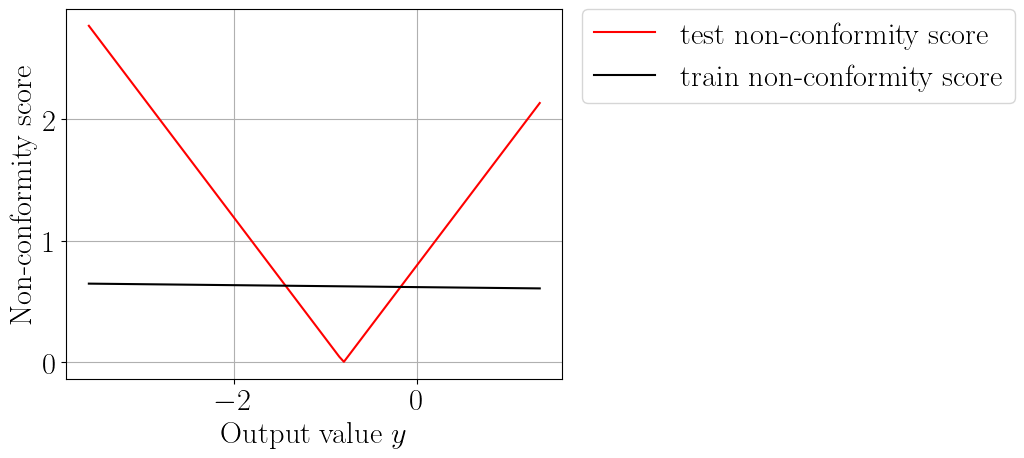

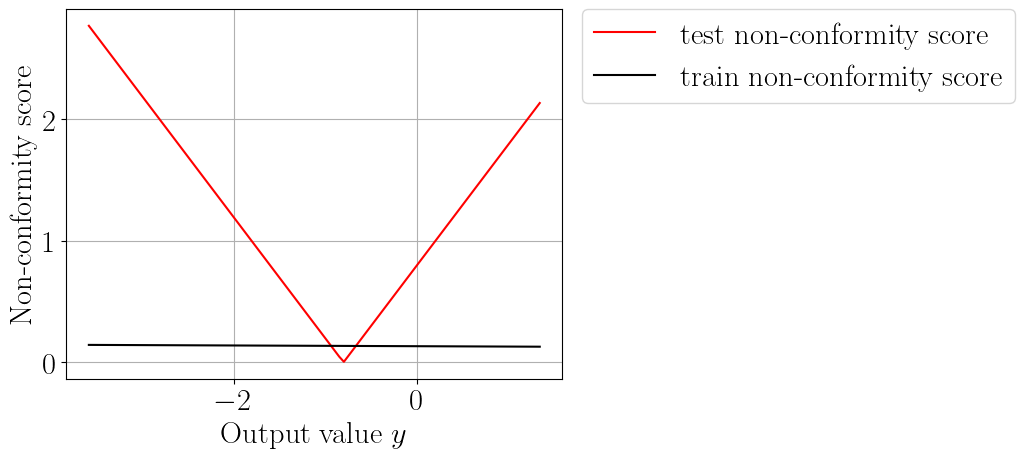

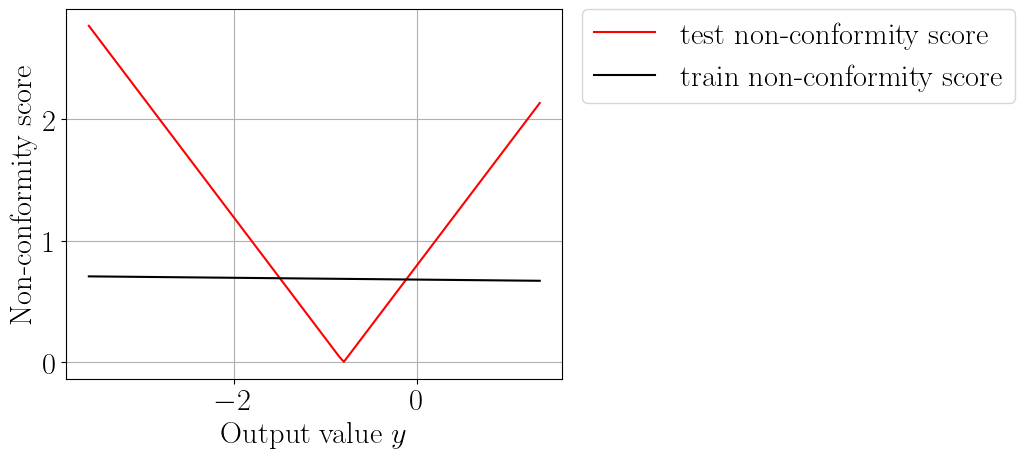

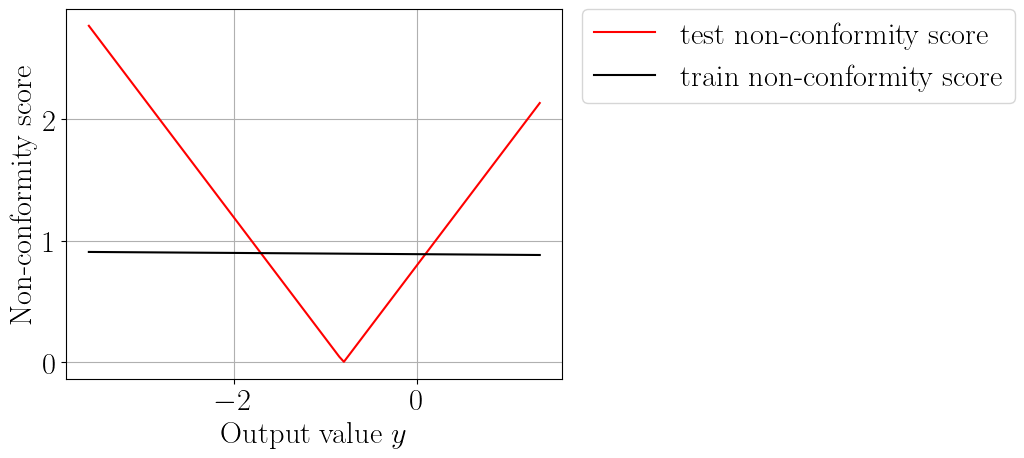

In [10]:
y_min = np.min(train_output_points)
y_max = np.max(train_output_points)
output_values = np.linspace(y_min, y_max, 100)

non_conformity_scores = np.array(
    [non_conformity_scores_(output_value) for output_value in output_values]
)

for i in range(min(sample_size, 10)):
    fig, ax = plt.subplots()
    ax.plot(
        output_values,
        non_conformity_scores[:, -1],
        color="red",
        label="test non-conformity score",
    )

    ax.plot(
        output_values,
        non_conformity_scores[:, i],
        color="k",
        label="train non-conformity score",
    )

    ax.set_ylabel("Non-conformity score")
    ax.set_xlabel(r"Output value $y$")
    ax.grid("on")
    ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

## Conformal p-value function

### Utils

In [11]:
def make_conformal_pvalue_function(non_conformity_scores_):
    def conformal_pvalue_function(output_value):
        non_conformity_scores = non_conformity_scores_(output_value)
        return (
            1 + np.sum(non_conformity_scores[:-1] >= non_conformity_scores[-1])
        ) / non_conformity_scores.shape[0]

    return conformal_pvalue_function

### Run

In [12]:
lam = 0.5
intercept, weight = compute_score_params(
    train_input_points, train_output_points, test_input_point, lam
)
non_conformity_scores_ = make_non_conformity_scores(intercept, weight)
conformal_pvalue_function = make_conformal_pvalue_function(non_conformity_scores_)

### Display

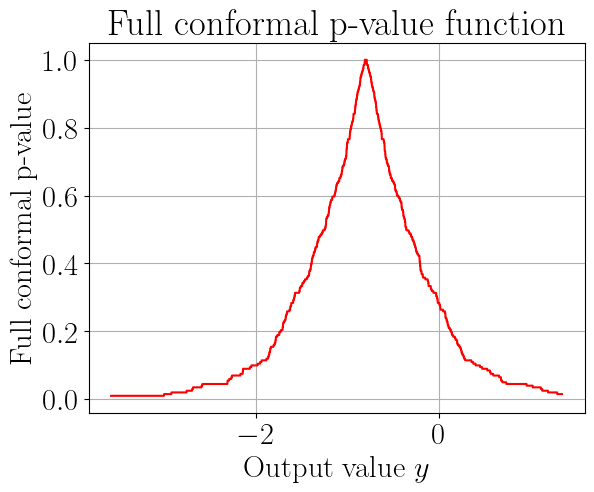

In [13]:
y_min = np.min(train_output_points)
y_max = np.max(train_output_points)
output_values = np.linspace(y_min, y_max, 10000)


conformal_pvalues = np.array(
    [conformal_pvalue_function(output_value) for output_value in output_values]
)

fig, ax = plt.subplots()
ax.plot(output_values, conformal_pvalues, color="red")

ax.set_title("Full conformal p-value function")
ax.set_ylabel("Full conformal p-value")
ax.set_xlabel(r"Output value $y$")
ax.grid("on")
# ax.legend()

## Full conformal prediction interval

### Utils

In [14]:
def make_interval(a, b, c, d):
    a = a * np.sign(b)
    b = np.abs(b)
    c = c * np.sign(d)
    d = np.abs(d)

    inter = P.empty()
    u = None
    v = None

    if b == 0:
        if d > 0:
            u = -(np.abs(a) - c) / d
            v = (np.abs(a) - c) / d
            inter = P.closed(u, v)

        elif np.abs(a) >= np.abs(c):
            u = -np.inf
            v = np.inf
            inter = P.open(u, v)
    else:
        if d == 0:
            u = (-np.abs(c) - a) / b
            v = (np.abs(c) - a) / b
            inter = P.open(u, v)
        else:
            if d == b:
                tmp = -(a + c) / (2 * b)
                if a > c:
                    u = tmp
                    v = np.inf
                    inter = P.closedopen(u, v)
                elif a < c:
                    u = -np.inf
                    v = tmp
                    inter = P.openclosed(u, v)
                else:
                    u = tmp
                    v = tmp
                    inter = P.closed(u, v)
            elif b > d:
                u = np.min(np.array([-a / b, (-a + c) / (b - d), -(a + c) / (b + d)]))
                v = np.max(np.array([-a / b, (-a + c) / (b - d), -(a + c) / (b + d)]))
                inter = P.openclosed(-np.inf, u).union(P.closedopen(v, np.inf))
            else:
                inter = P.closed(
                    max(-a / b, -(a + c) / (b + d)), (-a + c) / (b - d)
                ).union(P.closed((-a + c) / (b - d), min(-a / b, -(a + c) / (b + d))))
                u = inter.lower
                v = inter.upper

    return inter, u, v

In [15]:
# Taken from Ndiaye's stableCP
def my_ridgeCP(A, B, alpha):
    n_samples = A.shape[0] - 1
    S, U, V = [], [], []

    for i in range(n_samples):
        inter, u, v = make_interval(A[i], B[i], A[-1], B[-1])
        S += [inter]
        U += [u]
        V += [v]

    hat_y = np.sort([-np.inf] + U + V + [np.inf])
    size = hat_y.shape[0]
    conf_pred = P.empty()
    p_values = []

    for i in range(size - 1):

        n_pvalue_i = 0.0
        intvl_i = P.closed(hat_y[i], hat_y[i + 1])

        for j in range(n_samples):
            n_pvalue_i += intvl_i in S[j]

        p_value_i = (n_pvalue_i + 1) / (n_samples + 1)
        p_values.append(p_value_i)

        if p_value_i > alpha:
            conf_pred = conf_pred.union(intvl_i)

    return conf_pred, hat_y, np.array(p_values), S

### Run

In [16]:
lam = 0.5
confidence_control_level = 0.1

intercept, weight = compute_score_params(
    train_input_points, train_output_points, test_input_point, lam
)
non_conformity_scores_ = make_non_conformity_scores(intercept, weight)


prediction_region, my_hat_y, my_p_values, intervals = my_ridgeCP(
    intercept, weight, confidence_control_level
)

### Display

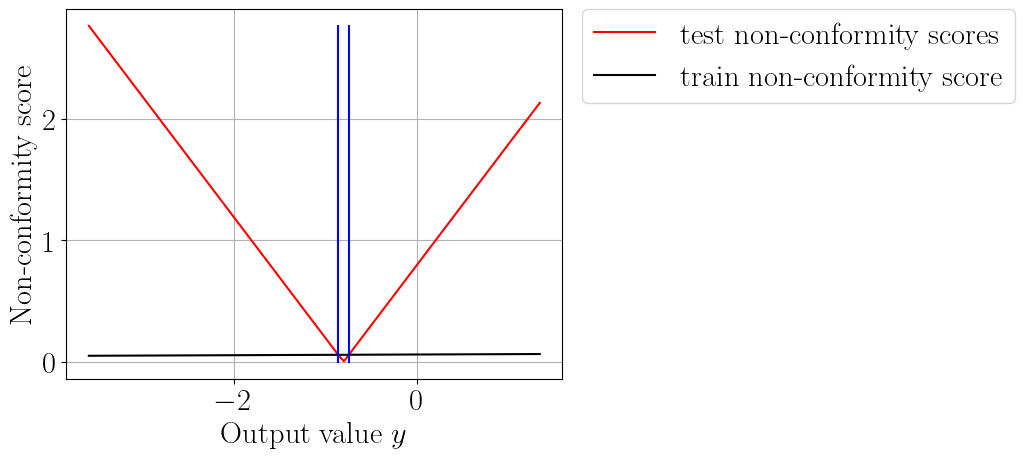

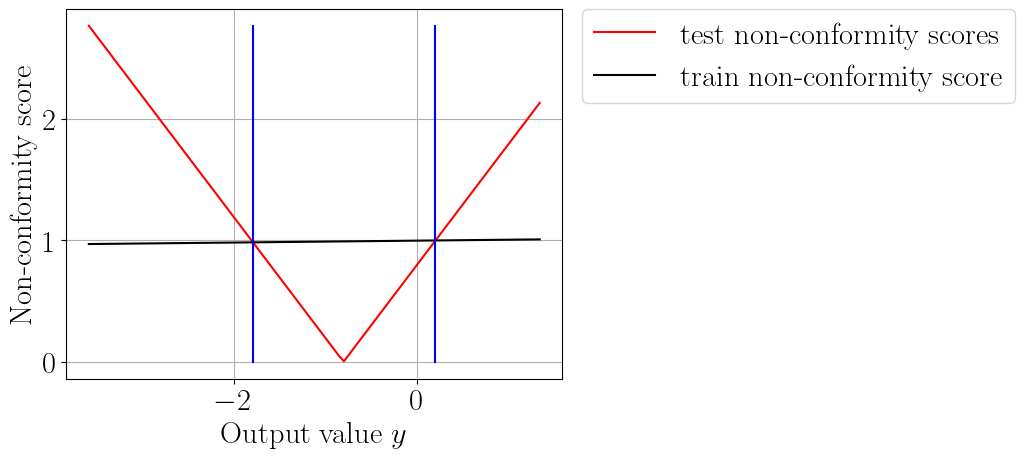

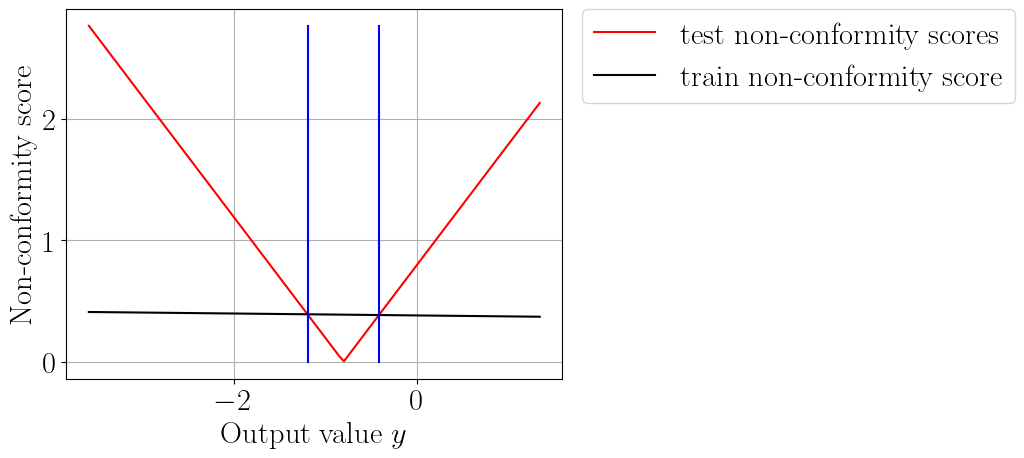

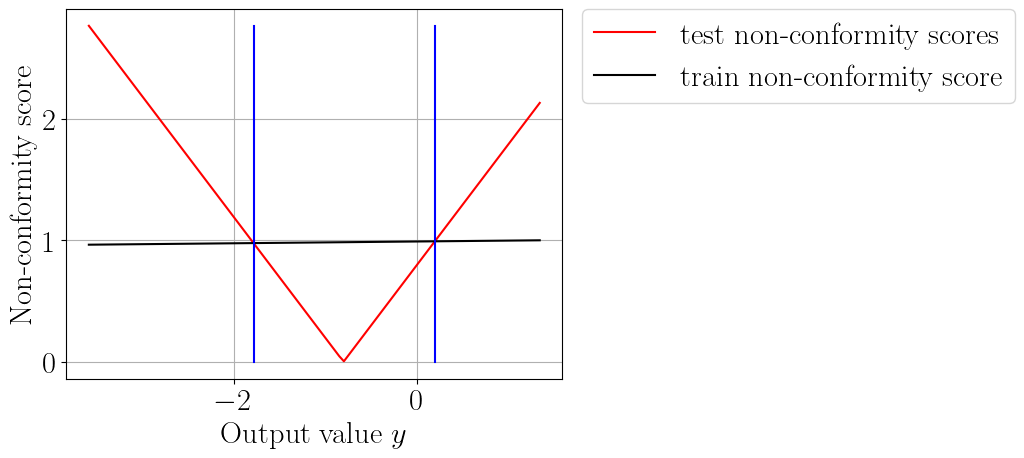

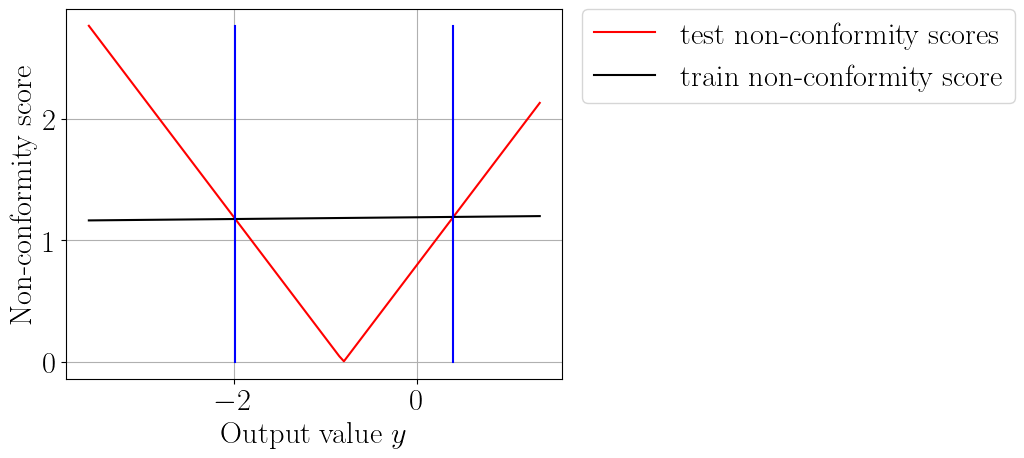

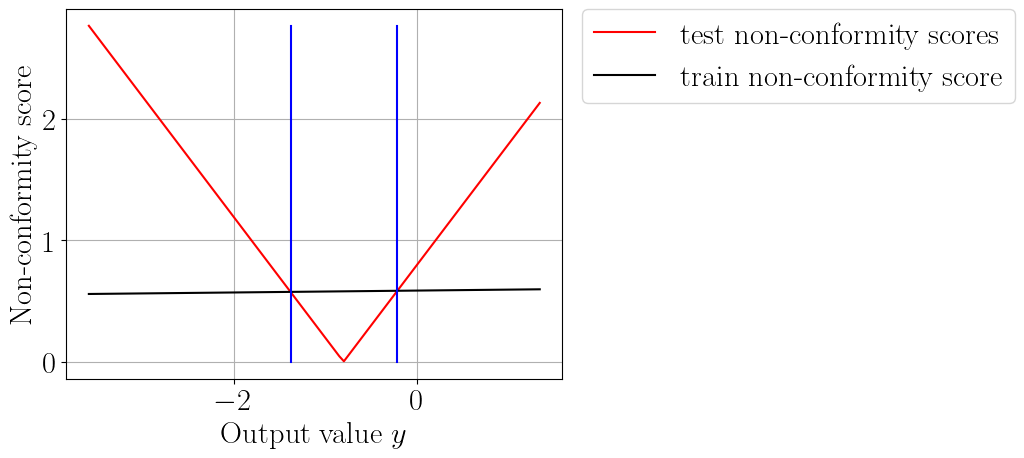

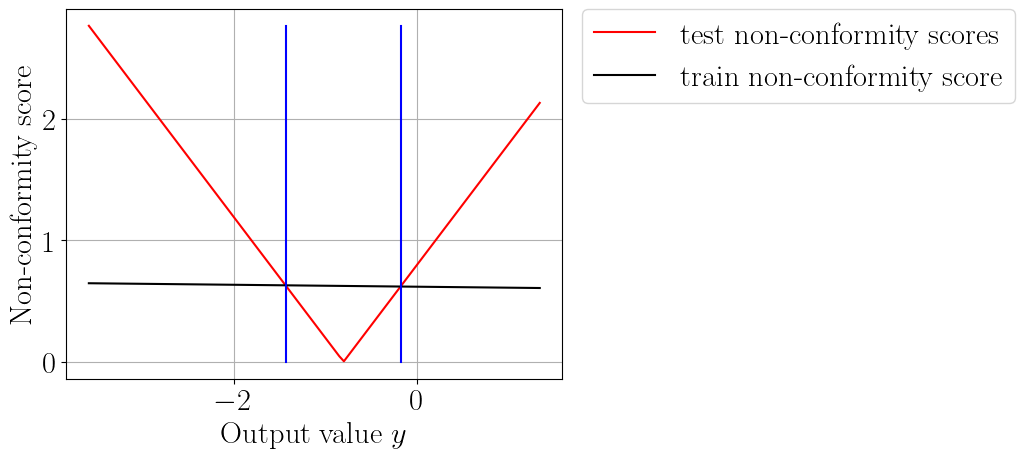

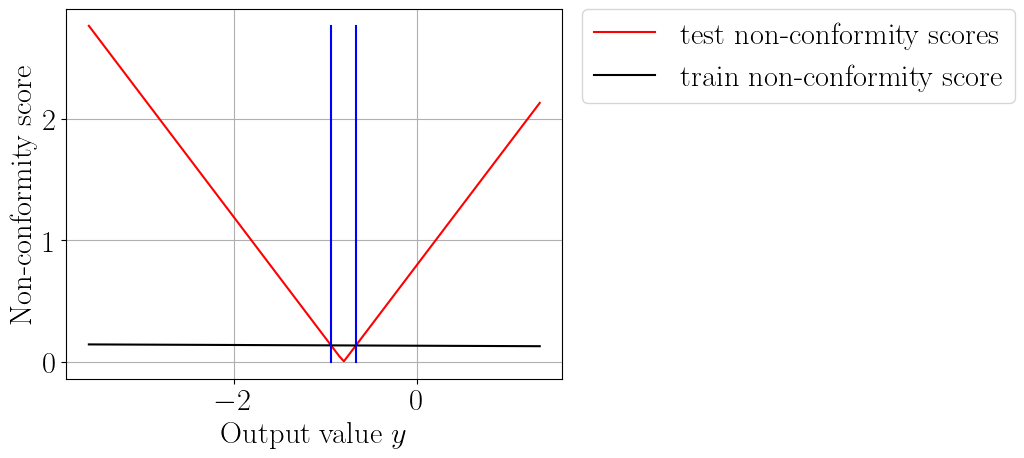

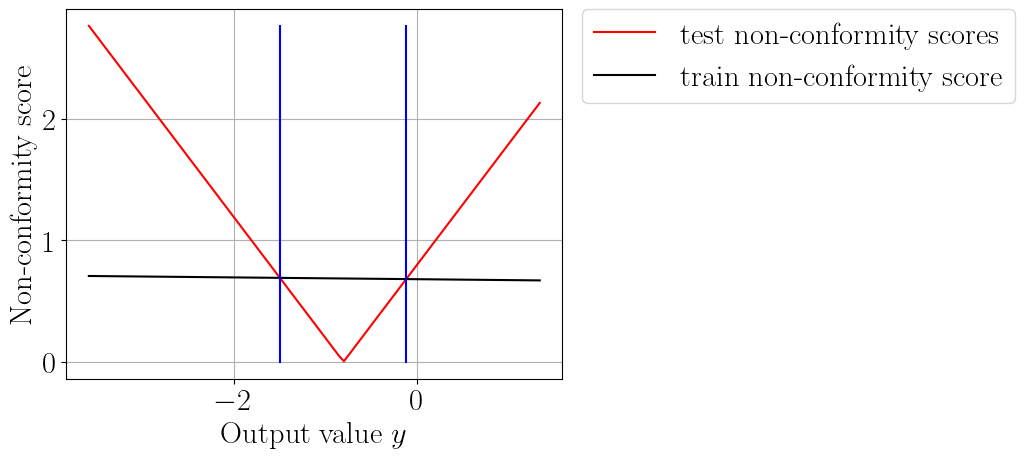

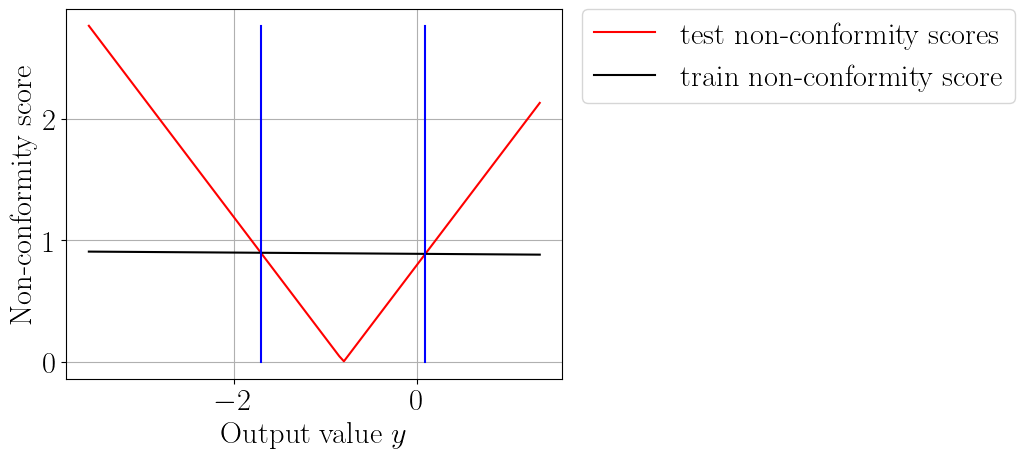

In [17]:
y_min = np.min(train_output_points)
y_max = np.max(train_output_points)
output_values = np.linspace(y_min, y_max, 100)

non_conformity_scores = np.array(
    [non_conformity_scores_(output_value) for output_value in output_values]
)


for i in range(min(sample_size, 10)):
    fig, ax = plt.subplots()
    ax.plot(
        output_values,
        non_conformity_scores[:, -1],
        color="red",
        label="test non-conformity scores",
    )

    ax.plot(
        output_values,
        non_conformity_scores[:, i],
        color="k",
        label="train non-conformity score",
    )

    ax.plot(
        [intervals[i].lower, intervals[i].lower],
        [0, np.max(non_conformity_scores[:, -1])],
        color="blue",
    )

    ax.plot(
        [intervals[i].upper, intervals[i].upper],
        [0, np.max(non_conformity_scores[:, -1])],
        color="blue",
    )

    ax.set_ylabel("Non-conformity score")
    ax.set_xlabel(r"Output value $y$")
    ax.grid("on")
    ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

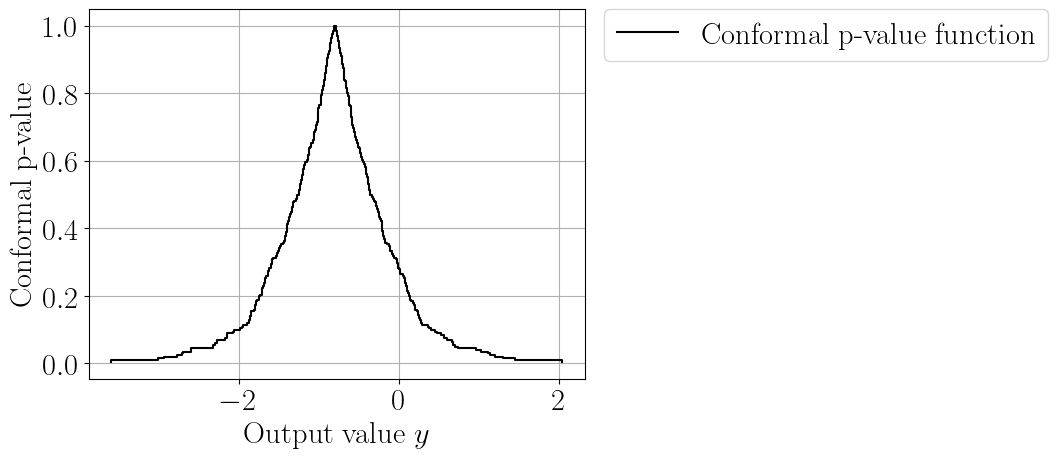

In [18]:
confidence_control_level = 0.1
prediction_region, my_hat_y, my_p_values, _ = my_ridgeCP(
    intercept, weight, confidence_control_level
)

prediction_region, hat_y, p_values, intervals = my_ridgeCP(
    intercept, weight, confidence_control_level
)

y_min = np.min(hat_y[1:-1])
y_max = np.max(hat_y[1:-1])

fig, ax = plt.subplots()
ax.step(my_hat_y[1:], my_p_values, color="k", label="Conformal p-value function")
ax.set_ylabel("Conformal p-value")
ax.set_xlabel(r"Output value $y$")
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

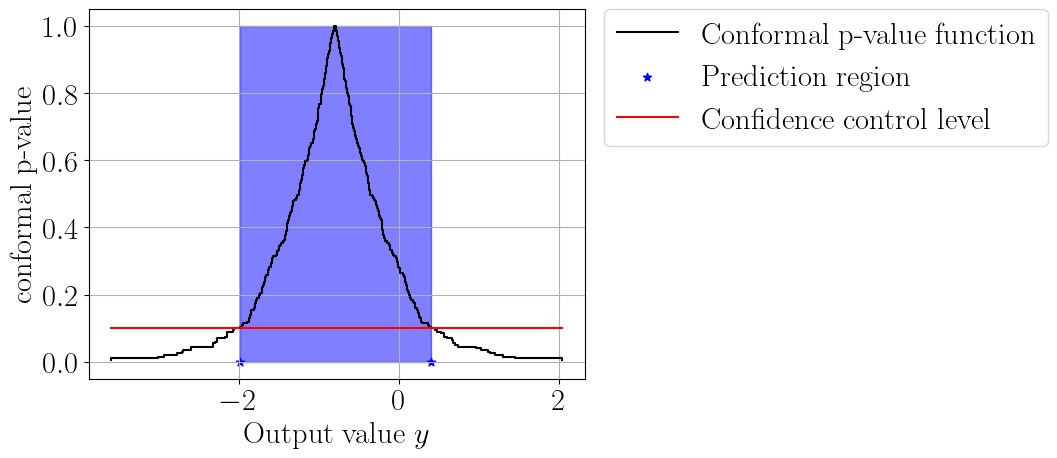

In [19]:
confidence_control_level = 0.1
prediction_region, my_hat_y, my_p_values, _ = my_ridgeCP(
    intercept, weight, confidence_control_level
)

prediction_region, hat_y, p_values, intervals = my_ridgeCP(
    intercept, weight, confidence_control_level
)

y_min = np.min(hat_y[1:-1])
y_max = np.max(hat_y[1:-1])

fig, ax = plt.subplots()
ax.step(my_hat_y[1:], my_p_values, color="k", label="Conformal p-value function")


ax.fill(
    [
        prediction_region.lower,
        prediction_region.lower,
        prediction_region.upper,
        prediction_region.upper,
    ],
    [0, 1, 1, 0],
    alpha=0.5,
    color="blue",
)

ax.scatter(
    [prediction_region.lower,
    prediction_region.upper],
    [0, 0], marker='*', color = "blue",
    label = "Prediction region"
)


ax.plot(
    [y_min, y_max],
    [confidence_control_level, confidence_control_level],
    color="r",
    label="Confidence control level",
)
ax.set_ylabel("conformal p-value")
ax.set_xlabel(r"Output value $y$")
ax.grid()
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

### Visu

In [20]:
def draw_interval(ax, ystart, ystop, x, color):
    ax.vlines(x, ystart, ystop, color, lw=4, alpha = 0.5, label="Prediction interval")
    ax.hlines(ystart, x+0.1, x-0.1, color, lw=1, alpha = 0.5)
    ax.hlines(ystop, x+0.1, x-0.1, color, lw=1, alpha = 0.5)
    return

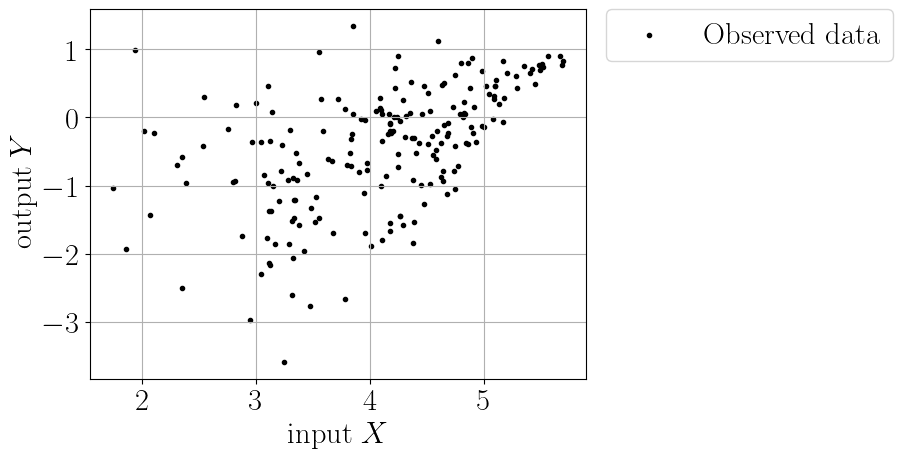

In [21]:
fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

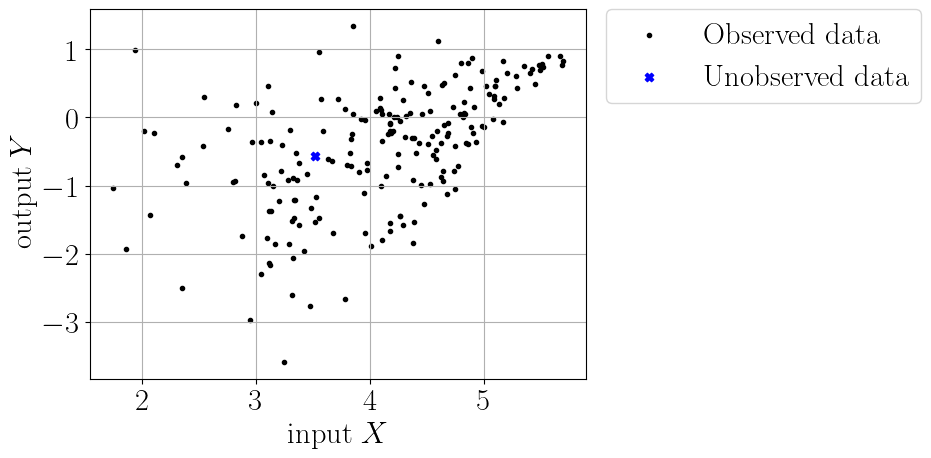

In [22]:
fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.scatter(test_input_point, test_output_point, label = "Unobserved data", marker="X", color="blue")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

In [23]:
def train_linear_regression(input_points, output_points, lam):
    # For polynomial regression
    input_points = poly.fit_transform(input_points)

    weight, _, _, _ = np.linalg.lstsq(
        (input_points.T @ input_points) / input_points.shape[0]
        + 2 * lam * np.eye(output_points.shape[1]),
        input_points.T @ output_points / input_points.shape[0],
    ) 
    return weight

def linear_predictor(input_points, weight):
    input_points = poly.fit_transform(input_points)
    return input_points @ weight

In [24]:
weight = train_linear_regression(train_input_points, train_output_points, lam)

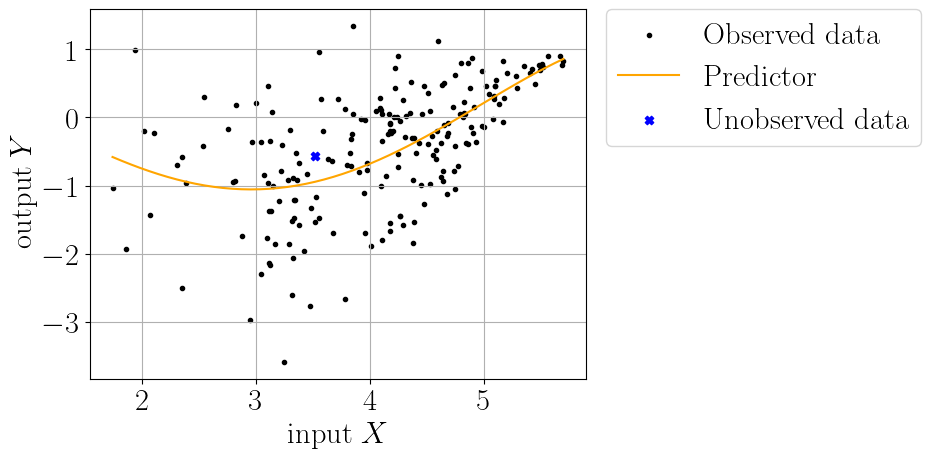

In [25]:
x_min = np.min(train_input_points)
x_max = np.max(train_input_points)
x_vals = np.linspace(x_min, x_max).reshape(-1, 1)


fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.plot(
    x_vals, linear_predictor(x_vals, weight),
    label = "Predictor", color = "orange"
)
ax.scatter(test_input_point, test_output_point, label = "Unobserved data", marker="X", color="blue")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

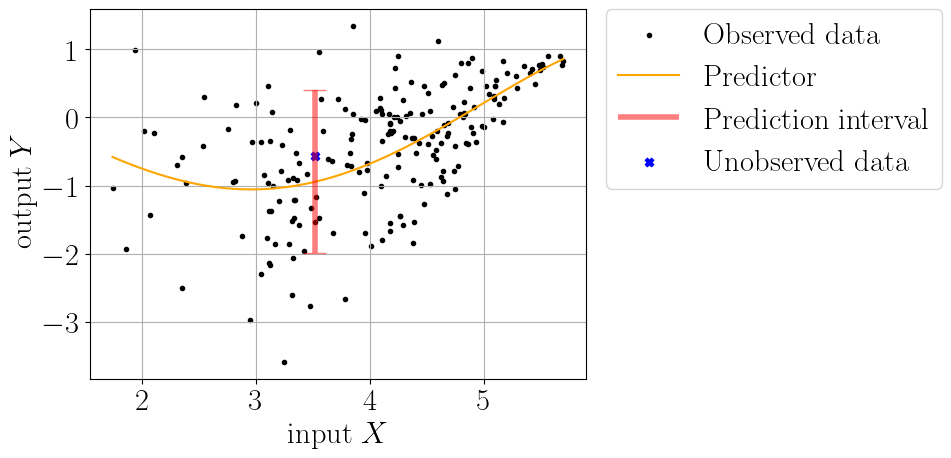

In [26]:
fig, ax = plt.subplots()
ax.scatter(train_input_points, train_output_points, label="Observed data", marker=".", color="k")
ax.plot(
    x_vals, linear_predictor(x_vals, weight),
    label = "Predictor", color = "orange"
)
draw_interval(ax, prediction_region.lower, prediction_region.upper, test_input_point.item(), "red")
ax.scatter(test_input_point, test_output_point, label = "Unobserved data", marker="X", color="blue")
ax.set_ylabel(r"output $Y$")
ax.set_xlabel(r"input $X$")
ax.grid("on")
ax.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)

## Evaluation of prediction region

### Utils

In [27]:
def interval_length(interval):
    """
    Compute the length of an interval

    Args:
        interval (P.closed): interval

    Returns:
        (float): interval length
    """
    if interval.empty:
        return 0
    length = 0
    for subinterval in interval:
        length += subinterval.upper - subinterval.lower
    return length


In [28]:
def labelize(name, coverage, compute_time, norm=1):

        cov = r"$\overline{cov}$ = "
        # mean_cov = str(df["coverage"].mean())
        mean_cov = str(np.round(np.mean(coverage), 2))
        Ts = r"$\overline{T}$ = "
        mean_time = str(np.round(np.mean(compute_time) / norm, 2))

        return name + " \n" + cov + mean_cov + "\n" + Ts + mean_time
        # return name + " \n" + cov + mean_cov

### Run

In [30]:
nb_rep = 100
confidence_control_level = 0.1
lam = 0.5


prediction_regions = []
coverage = []
compute_time = []
for iter in tqdm(range(nb_rep)):
    train_input_points, train_output_points, test_input_point, test_output_point = (
        sample_data_for_me(sample_size)
    )

    tic = time()
    intercept, weight = compute_score_params(
        train_input_points, train_output_points, test_input_point, lam
    )
    prediction_region, my_hat_y, my_p_values, intervals = my_ridgeCP(
        intercept, weight, confidence_control_level
    )
    tac = time()

    prediction_regions.append(prediction_region)
    coverage.append(test_output_point.item() in prediction_region)
    compute_time.append(tac - tic)
    
prediction_region_sizes = [
    interval_length(prediction_region) for prediction_region in prediction_regions
]


100%|██████████| 100/100 [00:13<00:00,  7.69it/s]


### Display

Text(0.5, 1.0, 'Length of prediction regions')

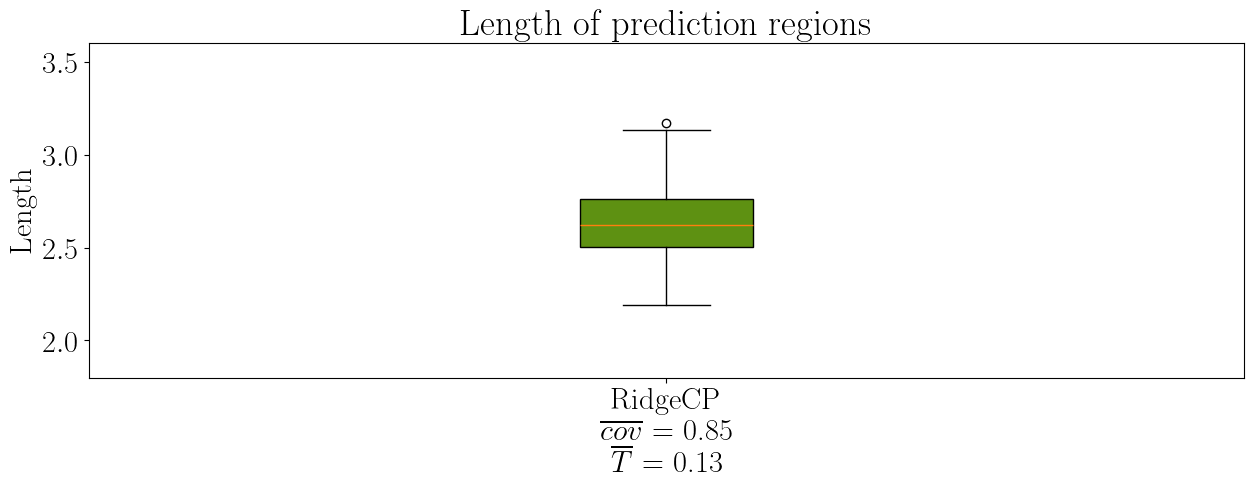

In [31]:
colors = ["#5E9112"]
labels = []
labels += [labelize("RidgeCP", coverage, compute_time)]

fig, ax = plt.subplots(figsize=(13,5))
box = ax.boxplot(prediction_region_sizes, patch_artist=True)
ax.set_ylabel("Length")
# plt.title(method + " : " + dataset)

for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

ax.grid(False)
ax.set_xticks(np.arange(1, len(labels) + 1), labels)
ax.set_ylim(1.8, 3.6)
fig.tight_layout()
ax.set_title("Length of prediction regions")